# AutoML Exercise

In [2]:
import pickle
import numpy as np
import matplotlib.pyplot as plt
from typing import List, Dict, Tuple

## 1. Introduction

In this exercise we will see how we can use Bayesian optimization [[Shahriari et al, 2016]](#4.-References) to optimize the hyperparameters of a feed-forward neural network (FC-Net).
We will also learn how we can empiricially evaluate hyperparameter optimization methods in practice.

Before you start, make sure you installed the following dependencies:
- numpy (pip install numpy)
- matplotlib (pip install matplotlib)
- scipy (pip install scipy)
- sklearn (pip install sklearn)
- pytorch (pip install torch)
- ConfigSpace (pip install ConfigSpace)
- hpobench (see https://github.com/automl/nas_benchmarks for how to install it. Note that, you need to download the data first from [here](http://ml4aad.org/wp-content/uploads/2019/01/fcnet_tabular_benchmarks.tar.gz))

To avoid, that you waste too much time training the FC-Net, we will not optimize the actual benchmark but instead use a  tabular benchmark [[Ying et al, 2019]](#4.-References) [[Klein et al, 2019]](#4.-References). In previous work, we first discretized the hyperparameter configuration space of the FC-Net and then performed an evaluated all hyperparameter configurations in that space multiple time. 
The results are compiled into a database, such that we can simply look up the performance of a hyperparameter configuration instead of training it from scratch.

The code below shows how we can load the benchmark together with the configuration space.
Each hyperparameter configuration is encoded as a `Configuration` object and we can easily convert it to a `numpy` array or a `dictionary`. Note that, if we convert it to a numpy array, all values are normalized to be in $[0, 1]$.

If we evaluate a hyperparameter configuration, we get the validation error and the time it had taken to train this configuration. When we generated this benchmark, we evaluated each hyperparameter configuration 4 times, and, for every table lookup, we pick one of these 4 trials uniformly at random. This simulates the typical noise that comes with hyperparameter optimization problems.

In [85]:
from nas_benchmarks.tabular_benchmarks import FCNetProteinStructureBenchmark
from nas_benchmarks.tabular_benchmarks.fcnet_benchmark import FCNetBenchmark

b = FCNetProteinStructureBenchmark(data_dir="./fcnet_tabular_benchmarks/")
cs = b.get_configuration_space()
config = cs.sample_configuration()

print("Numpy representation: ", config.get_array())
print("Dict representation: ", config.get_dictionary())

y, cost = b.objective_function(config)
print("Validation error: %f" % y)
print("Runtime %f" % cost)

Numpy representation:  [1. 0. 3. 1. 2. 0. 1. 5. 0.]
Dict representation:  {'activation_fn_1': 'relu', 'activation_fn_2': 'tanh', 'batch_size': 64, 'dropout_1': 0.3, 'dropout_2': 0.6, 'init_lr': 0.0005, 'lr_schedule': 'const', 'n_units_1': 512, 'n_units_2': 16}
Validation error: 0.340966
Runtime 116.655815


## 2. Random Search

To get started, we will first implement random search [[Bergstra et al, 2012]](#4.-References), which is, besides its simplicity, usually a quite tough baseline to beat. If you develop a new method, you should always first compare against random search to see whether it actually works or if there is still a bug somewhere.

The following function draws `n_iters` hyperparameter configurations uniformly at random from the configuration space and keeps track of the incumbent (i.e the best configuration we have seen so far) after each function evaluation. Since in this exercise we are also interested in comparing different hyperparameter optimization methods, we return the incumbent after each time steps together with its validation error. 

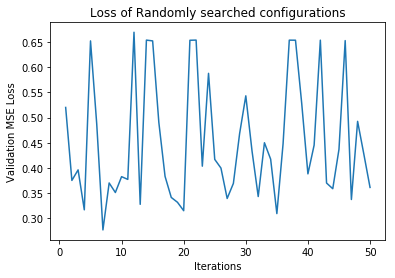

In [98]:
def random_search(benchmark: FCNetBenchmark, n_iters: int = 100):
    
    # get the configuration space
    cs = benchmark.get_configuration_space()
    
    incumbent = None  # the best observed configuration, might need to be updated after each function evaluation
    incumbent_val = np.inf
    
    # some bookkeeping
    runtime = []  # cumulative cost of the time we spend for function evaluations
    incumbent_trajectory = []  # the incumbent after each function evaluation
    incumbent_trajectory_error = []  # the corresponding validation error
    
    # start the random search loop
    for i in range(n_iters):
        
        #TODO: sample hyperparameter configuration
        config = cs.sample_configuration()
        
        #TODO: evaluate it
        valid_mse, run_time = b.objective_function(config)
        runtime.append(run_time)
        
        #TODO: check whether we improved upon the current incumbent
        if incumbent is None or valid_mse < incumbent_val:
            incumbent = config
            incumbent_val = valid_mse
            
        #TODO: updated incumbent trajectory
        incumbent_trajectory.append(incumbent)
        incumbent_trajectory_error.append(valid_mse)
        
    return incumbent_trajectory, incumbent_trajectory_error

incumbent, traj = random_search(benchmark=b, n_iters=50)
plt.plot(np.arange(1, 51), traj)
plt.xlabel('Iterations')
plt.ylabel('Validation MSE Loss')
plt.title('Loss of Randomly searched configurations');

## 3. Bayesian optimization

Now we we will implement Bayesian optimization [[Snoek et al, 2012]](#4.-References).
As we saw in the lecture, Bayesian optimization has two main ingredients: the probablistic model and the acquisition function. Since we have a discrete space here, we will first use random forest [[Breimann et al, 2001]](#4.-References) to model the objective function instead of Gaussian processes which are the usually used for continuous spaces. For the acquisition function we will use expected improvement which is probably the most popular one in the literature. Additionaly, we also need an optimizer to maximize the acquisition function, and, due to the discrete space, we cannot use standard optimizer, such as for example scipy.optimize. Instead, we will implemented a simple stochastic local search method.

Let's start with the model. We will we write a wrapper around sklearn's random forest module, which returns for a given test point only the mean prediction. However, to compute the acquisition function, we also need the predictive variance. For that, we first loop over the trees to get the individual tree predictions and then compute the mean and variance of them.

In [ ]:
from sklearn.ensemble import RandomForestRegressor

class RandomForest(object):
    
    def __init__(self, X: np.ndarray, y: np.ndarray) -> None:
        # TODO: Instantiate and train a random forest on the provided data
        
    def predict(self, X_test: np.ndarray) -> Tuple[np.ndarray, np.ndarray]:
        #TODO: Loop over tree and compute the mean and variance over the tree predictions
        
        return mean, variance

Next, we implement expected improvement. To compute the CDF and the PDF you can use the scipy functions: `scipy.norm.cdf` and `scipy.norm.pdf`.

In [ ]:
from scipy.stats import norm

def expected_improvement(candidates: np.ndarray, model, y_star: float) -> np.ndarray:
    # TODO: compute the improvement for the candidate points over y_star in expectation based on the model's predictions
    return ei

As already mentioned above, to optimize the acquisition function we will implement a simple local search method, which works as follows:
 1. start from an initial point `x_init`
 2. loop over all its one-step neighbours and compute the acquisition function values
 3. jump to the neighbour with the highest acquisition function value
 4. repeat step 2 and 3 until we either reach the maximum number of steps `n_steps` or we don't improve anymore
 5. return best found configuration

In [ ]:
import ConfigSpace
from ConfigSpace.util import get_one_exchange_neighbourhood  # see docstring: https://github.com/automl/ConfigSpace/blob/master/ConfigSpace/util.pyx for more details

def local_search(acquisition_function: func, model: Model, y_star: float,
                 x_init: ConfigSpace.Configuration, n_steps: int) -> ConfigSpace.Configuration:
    current_best = x_init
    current_best_value = f(x_init.get_array()[None, :])
    for i in range(n_steps):

        # TODO: evaluate one-step neighbourhood (hint: use get_one_exchange_neighbourhood function)
        
        # TODO: check whether we improved upon the current best
        
        # TODO: jump to the next neighbour if we improved
        
        # TODO: in case we converged, stop the local search
        
    return current_best

Now we have all our ingredients together, and we can finally implement the main Bayesian optimization loop.
Before we can fit a model, we need to collect some data first. This is called the initial design.
Various different initial design strategies exist, but here we will simply sample `n_init` random points.

Note that, like for random search, we want to benchmark Bayesian optimization later and need the performance of the incumbent over time. Make sure that you keep track of the incumbent and check after *each function evaluation* whether we improved.

In [ ]:
from functools import partial

def bayesian_optimization(benchmark: FCNetBenchmark, model, acquisition_function=expected_improvement,
                          optimizer=local_search, n_iters: int = 100, n_init: int = 5) -> None:
    # book keeping
    X = []
    y = []
    
    incumbent_trajectory = []
    incumbent_trajectory_error = []
    incumbent_val = np.inf
    incumbent = None
    
    # TODO: implement initial design by evaluating random configurations
    for i in range(n_init):
        
    # start main BO loop
    for i in range(n_init, n_iters):
        
        # TODO: fit model
        
        # TODO: optimize acquisition function to get candidate point
        
        # TODO: evaluate objective function at the candidate point
        
        # TODO: book keeping
        
    return incumbent_trajectory, incumbent_trajectory_error


In [ ]:
incumbent, traj = bayesian_optimization(b, RandomForest, n_iters=50)
plt.plot(np.arange(1, 51), traj)

As an additional model we will try DNGO [[Snoek et al, 2015]](#4.-References), which first fits a neural networks with a linear output layer.
After training, it chops off the output layer and uses Bayesian linear regression with the output of the last layer as basis functions.
During inference time, it pass the test data through the first layers and then uses the precomputed Basis linear regression terms (m, K) to compute the mean and the variance. For more details have a look in Section 3 in the paper by [[Snoek et al, 2015]](#4.-References).

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim

class Net(nn.Module):
    def __init__(self, n_inputs, n_units=50):
        super(Net, self).__init__()
        self.fc1 = nn.Linear(n_inputs, n_units)
        self.fc2 = nn.Linear(n_units, n_units)
        self.fc3 = nn.Linear(n_units, n_units)
        self.out = nn.Linear(n_units, 1)

    def forward(self, x):
        x = torch.tanh(self.fc1(x))
        x = torch.tanh(self.fc2(x))
        x = torch.tanh(self.fc3(x))
        return self.out(x)

    def basis_funcs(self, x):
        x = torch.tanh(self.fc1(x))
        x = torch.tanh(self.fc2(x))
        x = torch.tanh(self.fc3(x))
        return x

class DNGO(object):
    
    def __init__(self, X: np.ndarray, y: np.ndarray, num_epochs: int = 200) -> None:
        
        # TODO: create the neural network
        
        # TODO: implement the training loop
                
        # Hyperparameters for the Bayesian linear regression.
        # Note: in the paper they sample \alpha an \beta from the marginal log-likelihood 
        # However, for simplicity, we keep them fix
        self.alpha = 1E-3
        self.beta = 1000

        # TODO: compute the Bayesian linear regression terms
        
        
    def predict(self, X: np.ndarray) -> np.ndarray:
        
        # TODO: extract the basis functions
        
        # TODO: compute the mean and the variance based on the Bayesian linear regression terms

A major part in developing new optimizers is the empirical comparison to existing baselines.
Even though this is often cumbersome and frustrating, it is key to obtain a better understanding and hence to develop better methods.

Since the most algorithms are to a certain degree randomized, we need to perform independent runs of each method with a different intialization in order to draw statistical significant conclusions.
In practice, this is often problematic due to the high computational cost of the most hyperparameter optimization problems. With our tabular benchmarks however, we can easiliy afford multiple runs and are only limited by the optimizer's overhead.

In the code below we run each methods `30` times for `50` iterations and store the incumbent trajectories of each run. If we have parallel resources available, such as for instance with a compute cluster, it is good practice to parallelize everything as much as possible ot get the most efficient workload. However, since we compare only 3 methods for a moderate number of runs and iterations, we can afford it to run them sequentially.

In [ ]:
n_runs = 30
n_iters = 50
rs_results = np.zeros([n_runs, n_iters])
bo_rf_results = np.zeros([n_runs, n_iters])
bo_dngo_results = np.zeros([n_runs, n_iters])

rs_incumbents = []
bo_rf_incumbents = []
bo_dngo_incumbents = []

# TODO: evaluate each methods 'n_runs' times for 'n_iters' iterations

Another nice property of the tabular benchmarks is that we know the true global optimum (in terms of test error averaged over the four trials).
To estimate an optimzer's quality, a popular metric is the regret: $|y_{incumbent} - y_{\star}|$ which measures the difference between the performance $y_{\star}$ of the global optimum and the current incumbent performance $y_{incumbent}$.

In [ ]:
_, y_star_valid, y_star_test = b.get_best_configuration()

To get a robust estimated of an optimzer's performance, we first compute the regret and then plot the incumbent trajectory across all independent runs of each optimzer

In [ ]:
# TODO: plot mean validation regret of each methods averaged over all runs

plt.yscale("log")
plt.ylabel("validation regret")
plt.xlabel("number of function evaluations")

In practice, we are eventually interested in the test performance rather than the validation performance. Thus, it is also good practice to perform an offline evaluation to compute the test performance of all incumbents.
The tabular benchmarks allow us to do that efficiently and, as for the validation performance, we can again compute the regret to the true performance (y_star_test).

In [ ]:
# TODO: compute test performance for all methods and all runs and plot the average test regret

plt.yscale("log")
plt.ylabel("test regret")
plt.xlabel("number of function evaluations")

## 4. References

* L. Breimann (2001) *Random Forests*  Machine Learning
* J. Bergstra and Y. Bengio (2012) *Random Search for Hyper-Parameter Optimization* Journal of Machine Learning Research 

* B. Shahriari and K. Swersky and Z. Wang and R. Adams and N. de Freitas (2016), *Taking the Human Out of the Loop: {A} Review of {B}ayesian Optimization* Proceedings of the {IEEE}
  
* J. Snoek and H. Larochelle and R. P. Adams (2012) *Practical {B}ayesian Optimization of Machine Learning Algorithms* Proceedings of the 25th International Conference on Advances in Neural Information Processing Systems (NIPS'12)

* J. Snoek and O. Rippel and K. Swersky and R. Kiros and N. Satish and N. Sundaram and M. Patwary and Prabhat and R. Adams (2015) *Scalable {B}ayesian Optimization Using Deep Neural Networks* Proceedings of the 32nd International Conference on Machine Learning (ICML'15)
        
* C. Ying and A. Klein and E. Real and E. Christiansen and K. Murphy and F. Hutter (2019) *NAS-Bench-101: Towards Reproducible Neural Architecture Search* arXiv:1902.09635

* A. Klein and F. Hutter (2019) *Tabular Benchmarks for Joint Architecture and Hyperparameter Optimization* arXiv